In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms
from torchvision.models import ResNet18_Weights
import numpy as np
import matplotlib.pyplot as plt

In [7]:
# --- Environment ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)

# --- Preprocessing ---
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

def generate_random_images(num_samples=200, channels=3, height=64, width=64):
    X = torch.randn(num_samples, channels, height, width)  # Random images
    y = torch.randn(num_samples, 1)  # Targets as (N, 1)
    return X, y

X, y = generate_random_images()
train_size = int(0.8 * len(X))
train_dataset = TensorDataset(X[:train_size], y[:train_size])
test_dataset = TensorDataset(X[train_size:], y[train_size:])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=16, drop_last=True)

In [8]:
# --- Training and Evaluation Functions ---
def train_model(model, loader, optimizer, criterion, epochs=5):
    model.train()
    losses = []
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(loader)
        losses.append(avg_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")
    return losses

def evaluate_model(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for inputs, targets in loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    mse = total_loss / len(loader)
    print(f"Test MSE: {mse:.4f}")
    return mse

In [9]:
# --- 1. Linear Regression ---
class SimpleLinearRegression(nn.Module):
    def __init__(self, input_dim):
        super(SimpleLinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x.view(x.size(0), -1))  # Flatten inputs

lr_model = SimpleLinearRegression(3 * 64 * 64).to(device)
lr_optimizer = optim.Adam(lr_model.parameters(), lr=0.001)
lr_criterion = nn.MSELoss()

print("\n--- Linear Regression ---")
lr_losses = train_model(lr_model, train_loader, lr_optimizer, lr_criterion)
lr_mse = evaluate_model(lr_model, test_loader, lr_criterion)

# --- 2. Linear Regression with L1 and L2 Regularization ---
class RegularizedLinearRegression(nn.Module):
    def __init__(self, input_dim):
        super(RegularizedLinearRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x.view(x.size(0), -1))

def l1_l2_regularization(model, lambda_l1=0.01, lambda_l2=0.01):
    l1_loss = sum(torch.norm(param, 1) for param in model.parameters())
    l2_loss = sum(torch.norm(param, 2) ** 2 for param in model.parameters())
    return lambda_l1 * l1_loss + lambda_l2 * l2_loss

reg_model = RegularizedLinearRegression(3 * 64 * 64).to(device)
reg_optimizer = optim.Adam(reg_model.parameters(), lr=0.001)
reg_criterion = nn.MSELoss()

print("\n--- Linear Regression with L1 and L2 Regularization ---")
reg_losses = []
epochs = 5
for epoch in range(epochs):
    reg_model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        reg_optimizer.zero_grad()
        outputs = reg_model(inputs)
        mse_loss = reg_criterion(outputs, targets)
        reg_loss = mse_loss + l1_l2_regularization(reg_model, 0.01, 0.01)
        reg_loss.backward()
        reg_optimizer.step()
        total_loss += reg_loss.item()
    avg_loss = total_loss / len(train_loader)
    reg_losses.append(avg_loss)
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.4f}")

reg_mse = evaluate_model(reg_model, test_loader, reg_criterion)

# --- 3. Linear Regression with Transfer Learning ---
class FeatureExtractorWithRegressor(nn.Module):
    def __init__(self, backbone):
        super(FeatureExtractorWithRegressor, self).__init__()
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        self.regressor = nn.Linear(backbone.fc.in_features, 1)

    def forward(self, x):
        features = self.backbone(x)
        return self.regressor(features.view(features.size(0), -1))

base_model = models.resnet18(weights=ResNet18_Weights.DEFAULT).to(device)
for param in base_model.parameters():
    param.requires_grad = False

transfer_model = FeatureExtractorWithRegressor(base_model).to(device)
transfer_optimizer = optim.Adam(transfer_model.regressor.parameters(), lr=0.001)
transfer_criterion = nn.MSELoss()

print("\n--- Linear Regression with Transfer Learning ---")
transfer_losses = train_model(transfer_model, train_loader, transfer_optimizer, transfer_criterion)
transfer_mse = evaluate_model(transfer_model, test_loader, transfer_criterion)


--- Linear Regression ---
Epoch 1/5, Loss: 1.4453
Epoch 2/5, Loss: 8.3984
Epoch 3/5, Loss: 1.1807
Epoch 4/5, Loss: 1.7912
Epoch 5/5, Loss: 0.6884
Test MSE: 0.9427

--- Linear Regression with L1 and L2 Regularization ---
Epoch 1/5, Loss: 1.8909
Epoch 2/5, Loss: 9.6520
Epoch 3/5, Loss: 1.5981
Epoch 4/5, Loss: 2.1654
Epoch 5/5, Loss: 1.1077
Test MSE: 0.9072

--- Linear Regression with Transfer Learning ---
Epoch 1/5, Loss: 1.4957
Epoch 2/5, Loss: 1.2113
Epoch 3/5, Loss: 1.0739
Epoch 4/5, Loss: 1.1301
Epoch 5/5, Loss: 0.8908
Test MSE: 1.1539


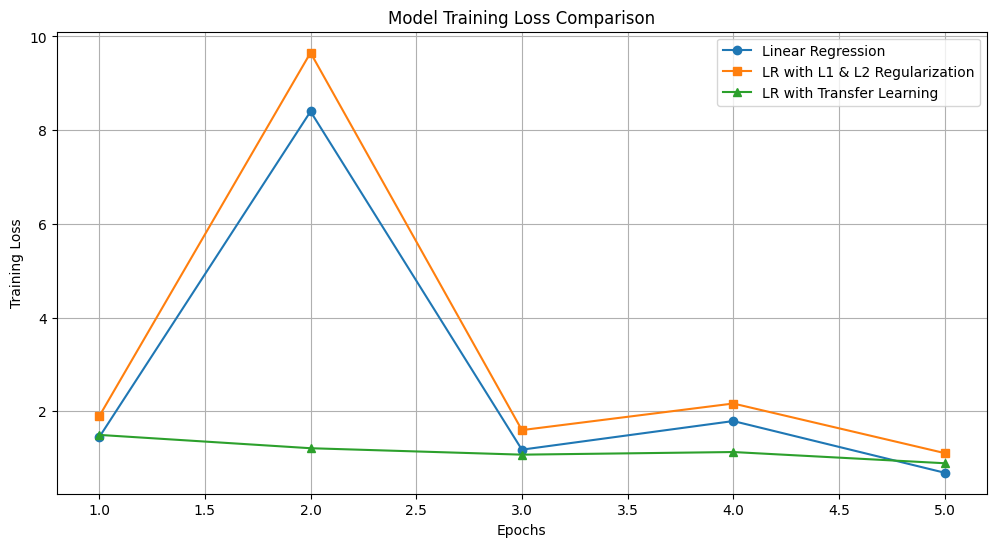


Final Test MSEs:
- Linear Regression: 0.9427
- LR with L1 & L2 Regularization: 0.9072
- LR with Transfer Learning: 1.1539


In [10]:
# --- Visualization ---
plt.figure(figsize=(12, 6))
epochs_range = range(1, 6)
plt.plot(epochs_range, lr_losses, label="Linear Regression", marker='o')
plt.plot(epochs_range, reg_losses, label="LR with L1 & L2 Regularization", marker='s')
plt.plot(epochs_range, transfer_losses, label="LR with Transfer Learning", marker='^')

plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Model Training Loss Comparison")
plt.legend()
plt.grid(True)
plt.show()

print(f"\nFinal Test MSEs:\n- Linear Regression: {lr_mse:.4f}\n- LR with L1 & L2 Regularization: {reg_mse:.4f}\n- LR with Transfer Learning: {transfer_mse:.4f}")